<a href="https://colab.research.google.com/github/mysticalScientist23/HR-Employee-Attrition/blob/master/Challenge_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
The National Surveys on Energy and Environment (NSEE) was a biannual national opinion survey on energy and climate policy. It was fielded by the Muhlenberg College Institute of Public Opinion, and results were published for public use online. More information is available at http://closup.umich.edu/national-surveys-on-energy-and-environment/.

For my project, I'll use the survey distributed in 2017. Variables include categorical survey responses representing level of support for various statements about politics and climate change, as well as demographic information. I'll use unsupervised learning models on survey responses to see if I can uncover any clusters. I hypothesize the models will cluster by political affiliation.

# Installing libraries

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import time

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Importing and cleaning data

In [0]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ZFcswlbqQZI_V9SaXbtz3K8vCrgNqAFSrUsehYZim7k/edit#gid=2143391572')
sheet = wb.worksheet('NSEE_Fall_2017_PUD')
data = sheet.get_all_values()
nsee_df = pd.DataFrame(data)
nsee_df.columns = nsee_df.iloc[0]
nsee_df = nsee_df.iloc[1:]
nsee_df.head(10)

,RSPDNUM,Sample,version_weather_v1,version_CDR,demog_age_year,AgeRecode,demog_state,Region,weather_pastsummer_v1,gw_belief,believer_confidence,believer_cause,believer_cause_followup,believer_problem,believer_immediacy,believer_factor_open,believer_factor_open_coded,believer_factor_glaciers,believer_factor_warmer,believer_factor_hurricane,believer_factor_mildwint,believer_factor_droughts,nonbeliever_confidence,nonbeliever_factor_open,nonbeliever_factor_open_coded,govt_fed,govt_state,govt_local,state_cleancoal,state_vehicles_v1,state_fftax,state_nuclear,state_captrade,state_rps_v2,natgas_mystate,govt_nofedaction,state_impactsfelt,state_rps_neighbr,cdr_knowledge_info,cdr_knowledge,cdr_support,gw_threat,coalfpp_support_phaseout_v2,subsidy_support,carbontax_support_v3,state_gastax_v2,state_ee_v2,gw_geoengr,gw_adapt,fed_moralobligation,intl_economicimpact,worldviews_freetrade,worldviews_immigration,willing2pay_list,demog_race,demog_relig,demog_relig_evang,demog_edu,demog_polparty,demog_polviews,worldviews_trump,demog_income,demog_gender,Date,Weight
1,1,C,B,C,9999,4,NJ,1,3,1,1,1,,1,1,OZONE LAYER,10,2,4,2,2,1,,,,1,2,3,4,1,1,1,4,1,1,1,1,4,999,999,999,5,1,1,1,2,1,98,4,1,4,1,4,6,1,6,,5,1,5,4,6,1,10/4/2017 5:25:51,0.18
2,2,C,A,C,9999,3,NC,2,3,2,,,,,,,,,,,,,3,JUST NORMA WEATHER,1,1,1,2,2,2,3,3,2,1,3,1,3,2,999,999,999,2,4,2,5,5,2,3,3,1,2,4,98,3,1,2,,3,2,3,2,6,1,10/4/2017 5:36:53,0.415
3,3,C,B,C,9999,1,TX,2,2,1,1,3,1,1,1,ICE CAPS ARE MELTING,1,2,1,1,3,1,,,,2,2,2,4,2,2,4,3,1,3,1,2,1,999,999,999,4,4,1,1,2,2,1,4,1,4,2,3,2,5,98,,1,,,4,3,1,10/4/2017 5:37:12,1.71
4,4,C,A,C,9999,2,VA,2,5,2,,,,,,,,,,,,,3,CYCLES,2,3,3,3,98,4,4,3,3,1,3,3,4,1,999,999,999,1,5,1,5,5,2,3,2,2,3,4,1,1,1,6,,3,2,2,1,4,1,10/4/2017 5:38:35,1.03
5,5,C,B,C,9999,3,MA,1,5,1,2,2,,3,2,WARMER,2,98,3,3,3,3,,,,3,3,3,98,4,4,1,98,4,1,4,4,1,999,999,999,2,1,4,5,5,5,98,1,4,1,2,1,1,1,1,2,2,2,2,1,6,1,10/4/2017 5:42:27,0.795
6,6,C,A,C,9999,2,MD,2,2,98,,,,,,,,,,,,,,,,3,2,1,1,1,4,4,2,1,1,1,4,3,999,999,999,2,4,2,1,5,1,4,4,1,4,4,4,4,9,1,2,2,4,1,4,3,1,10/4/2017 5:47:06,3.21
7,7,C,B,C,9999,3,VA,2,5,98,,,,,,,,,,,,,,,,3,3,3,2,3,4,4,3,4,98,2,3,2,999,999,999,2,5,5,5,5,2,2,3,3,3,2,3,1,,,,4,4,1,2,,1,10/4/2017 5:51:04,0.455
8,8,C,A,C,9999,4,TX,2,5,2,,,,,,,,,,,,,2,ITS PRETTY REGULAR,9,2,3,2,1,1,4,1,1,1,2,4,4,1,999,999,999,2,5,2,5,5,1,1,4,1,1,4,1,2,1,2,,3,2,1,1,6,2,10/4/2017 5:51:53,0.75
9,9,C,B,C,9999,1,IN,3,1,1,1,1,,1,1,DATA FROM LAST 200 YRS THAT SHOW THAT THE TEMP...,4,1,1,1,4,2,,,,1,2,2,,2,2,2,4,1,4,1,2,1,999,999,999,5,2,1,3,1,3,3,4,1,4,1,98,3,1,7,,4,4,4,4,4,2,10/4/2017 5:56:05,1.13
10,10,C,B,C,9999,1,FL,2,1,1,1,1,,1,1,HABITATS ARE BEING DESTROYED,7,1,2,1,4,3,,,,1,2,2,1,4,1,1,1,1,1,2,1,98,999,999,999,4,1,1,1,5,1,98,4,1,98,1,4,4,9,1,1,4,1,4,4,3,1,10/4/2017 5:58:21,2.6


In [0]:
# changing 98 to 0, 98 signifies 'Not sure' throughout the survey
nsee_df = nsee_df.replace('98', 0)

In [0]:
# changing blank entires to null
nsee_df = nsee_df.replace('', np.nan)

In [0]:
nsee_df.columns

Index(['RSPDNUM', 'Sample', 'version_weather_v1', 'version_CDR',
       'demog_age_year', 'AgeRecode', 'demog_state', 'Region',
       'weather_pastsummer_v1', 'gw_belief', 'believer_confidence',
       'believer_cause', 'believer_cause_followup', 'believer_problem',
       'believer_immediacy', 'believer_factor_open',
       'believer_factor_open_coded', 'believer_factor_glaciers',
       'believer_factor_warmer', 'believer_factor_hurricane',
       'believer_factor_mildwint', 'believer_factor_droughts',
       'nonbeliever_confidence', 'nonbeliever_factor_open',
       'nonbeliever_factor_open_coded', 'govt_fed', 'govt_state', 'govt_local',
       'state_cleancoal', 'state_vehicles_v1', 'state_fftax', 'state_nuclear',
       'state_captrade', 'state_rps_v2', 'natgas_mystate', 'govt_nofedaction',
       'state_impactsfelt', 'state_rps_neighbr', 'cdr_knowledge_info',
       'cdr_knowledge', 'cdr_support', 'gw_threat',
       'coalfpp_support_phaseout_v2', 'subsidy_support',
       'car

In [0]:
# for this project, I only want to include survey questions with ordinal categories
# for example 1-strongly support to 4-strongly oppose

nsee_df = nsee_df[['govt_fed', 'govt_state', 'govt_local', 'state_cleancoal', 
                   'state_vehicles_v1', 'state_fftax', 'state_nuclear',
                   'state_captrade', 'state_rps_v2', 'natgas_mystate',
                   'govt_nofedaction', 'state_impactsfelt', 'state_rps_neighbr',
                   'gw_threat', 'coalfpp_support_phaseout_v2', 'subsidy_support',
                   'carbontax_support_v3', 'state_gastax_v2', 'state_ee_v2',
                   'gw_geoengr', 'gw_adapt', 'fed_moralobligation', 
                   'intl_economicimpact', 'worldviews_freetrade',
                   'worldviews_immigration', 'willing2pay_list', 'demog_polviews',
                   'worldviews_trump', 'demog_income']]

In [0]:
# updating data types to float
nsee_df = nsee_df.astype(float)

In [0]:
nsee_df.shape

(929, 29)

In [0]:
nsee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 1 to 929
Data columns (total 29 columns):
govt_fed                       929 non-null float64
govt_state                     929 non-null float64
govt_local                     929 non-null float64
state_cleancoal                924 non-null float64
state_vehicles_v1              929 non-null float64
state_fftax                    926 non-null float64
state_nuclear                  927 non-null float64
state_captrade                 927 non-null float64
state_rps_v2                   928 non-null float64
natgas_mystate                 928 non-null float64
govt_nofedaction               926 non-null float64
state_impactsfelt              925 non-null float64
state_rps_neighbr              925 non-null float64
gw_threat                      926 non-null float64
coalfpp_support_phaseout_v2    925 non-null float64
subsidy_support                924 non-null float64
carbontax_support_v3           926 non-null float64
state_gasta

In [0]:
nsee_df.describe().round(2)

,govt_fed,govt_state,govt_local,state_cleancoal,state_vehicles_v1,state_fftax,state_nuclear,state_captrade,state_rps_v2,natgas_mystate,govt_nofedaction,state_impactsfelt,state_rps_neighbr,gw_threat,coalfpp_support_phaseout_v2,subsidy_support,carbontax_support_v3,state_gastax_v2,state_ee_v2,gw_geoengr,gw_adapt,fed_moralobligation,intl_economicimpact,worldviews_freetrade,worldviews_immigration,willing2pay_list,demog_polviews,worldviews_trump,demog_income
count,929.00,929.00,929.00,924.00,929.00,926.00,927.00,927.00,928.00,928.00,926.00,925.00,925.00,926.00,925.00,924.00,926.00,927.00,925.00,922.00,924.00,924.00,923.00,924.00,904.00,921.0,861.00,911.00,684.00
mean,1.60,1.75,1.91,1.82,1.98,2.60,2.17,1.84,1.62,1.62,2.14,2.01,2.19,3.26,2.62,1.79,3.11,3.72,2.13,1.85,3.08,1.83,2.29,1.85,2.64,2.4,2.74,2.89,3.66
std,0.82,0.81,0.86,1.24,1.18,1.33,1.42,1.38,1.02,1.24,1.19,1.30,1.38,1.40,1.70,1.33,1.69,1.58,1.43,1.39,1.21,1.15,1.51,1.14,1.41,1.7,1.26,1.14,1.91
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
25%,1.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,2.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.0,2.00,2.00,2.00
50%,1.00,2.00,2.00,2.00,2.00,3.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,3.00,2.00,1.00,3.00,5.00,2.00,2.00,4.00,2.00,2.00,2.00,3.00,2.0,3.00,3.00,4.00
75%,2.00,2.00,3.00,2.00,3.00,4.00,4.00,3.00,2.00,2.00,3.00,3.00,3.00,4.00,4.00,2.00,5.00,5.00,3.00,3.00,4.00,2.00,4.00,2.00,4.00,4.0,4.00,4.00,6.00
max,3.00,3.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,4.00,4.00,4.00,4.00,4.00,6.0,5.00,4.00,6.00


# Feature engineering

## Nulls

In [0]:
# looking for nulls by column
nsee_df.isna().sum()

0
govt_fed                         0
govt_state                       0
govt_local                       0
state_cleancoal                  5
state_vehicles_v1                0
state_fftax                      3
state_nuclear                    2
state_captrade                   2
state_rps_v2                     1
natgas_mystate                   1
govt_nofedaction                 3
state_impactsfelt                4
state_rps_neighbr                4
gw_threat                        3
coalfpp_support_phaseout_v2      4
subsidy_support                  5
carbontax_support_v3             3
state_gastax_v2                  2
state_ee_v2                      4
gw_geoengr                       7
gw_adapt                         5
fed_moralobligation              5
intl_economicimpact              6
worldviews_freetrade             5
worldviews_immigration          25
willing2pay_list                 8
demog_polviews                  68
worldviews_trump                18
demog_income      

In [0]:
# looking for nulls by row
row_nulls = nsee_df.isna().sum(axis=1).sort_values(ascending=False)
print(row_nulls)

248    24
846    12
821     7
591     6
264     6
       ..
555     0
554     0
552     0
551     0
1       0
Length: 929, dtype: int64


In [0]:
nsee_df.loc[[248,846,821]]

,govt_fed,govt_state,govt_local,state_cleancoal,state_vehicles_v1,state_fftax,state_nuclear,state_captrade,state_rps_v2,natgas_mystate,govt_nofedaction,state_impactsfelt,state_rps_neighbr,gw_threat,coalfpp_support_phaseout_v2,subsidy_support,carbontax_support_v3,state_gastax_v2,state_ee_v2,gw_geoengr,gw_adapt,fed_moralobligation,intl_economicimpact,worldviews_freetrade,worldviews_immigration,willing2pay_list,demog_polviews,worldviews_trump,demog_income
248,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,2.0,2.0,2.0,2.0,2.0,4.0,3.0,0.0,3.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,2.0,2.0,6.0
821,1.0,2.0,2.0,2.0,1.0,4.0,3.0,2.0,4.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0,5.0


In [0]:
# dropping 1 row with 24 nulls
nsee_df = nsee_df.drop([248], axis=0)

In [0]:
# reseting index
nsee_df = nsee_df.reset_index(drop=True)

In [0]:
# filling remaining nulls with mode of each column
for column in nsee_df.columns:
    nsee_df[column].fillna(nsee_df[column].mode()[0], inplace=True)

## Exploring distributions

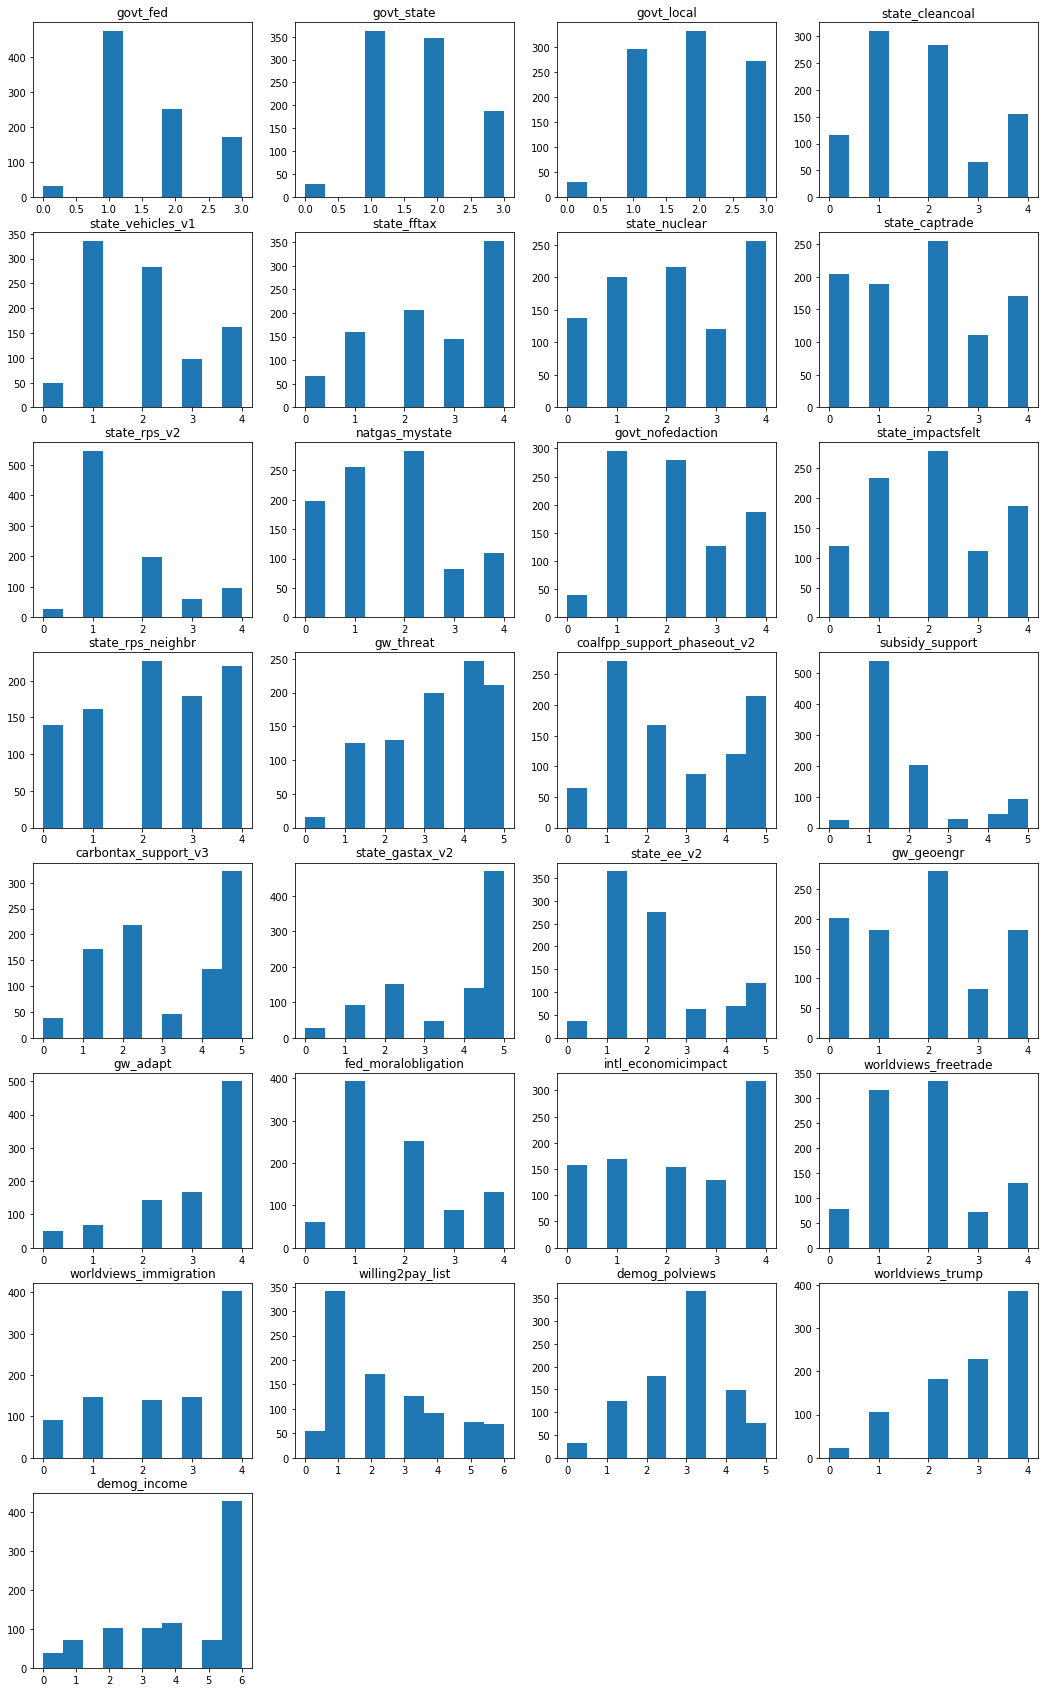

In [0]:
x=1
plt.figure(figsize=(18,38))
for col in nsee_df.columns:
  plt.subplot(10,4,x)
  plt.hist(nsee_df[col])
  plt.title(col)
  x=x+1

**Obervations:**
- As expected, all variables range from 0 to 3,4,5, or 6, representing survey answer categories.
- Many of these variables are imbalanced, with one or two categories recieving the most responses.

## Exploring collinearity

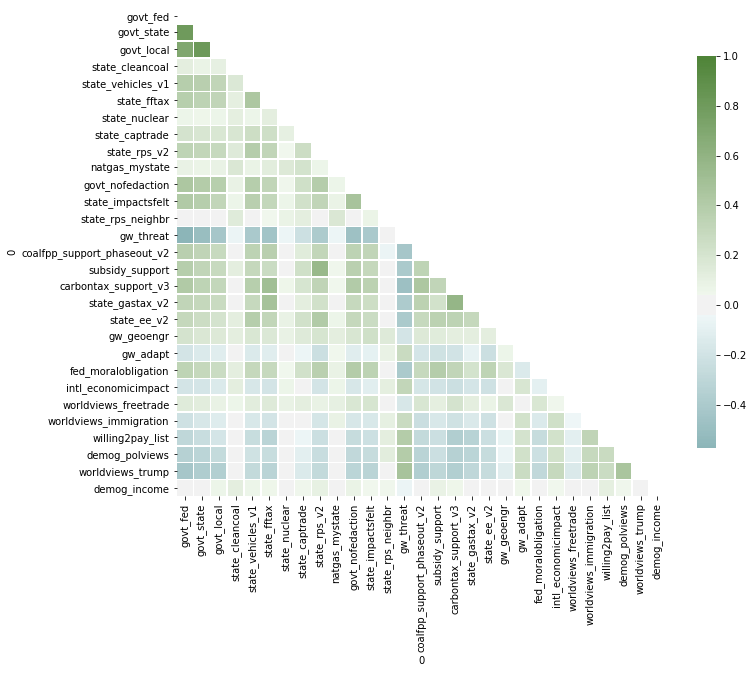

In [0]:
nsee_corr = nsee_df.corr()
mask = np.triu(np.ones_like(nsee_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(200, -600, as_cmap=True)
sns.heatmap(nsee_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8});

In [0]:
nsee_corr

,govt_fed,govt_state,govt_local,state_cleancoal,state_vehicles_v1,state_fftax,state_nuclear,state_captrade,state_rps_v2,natgas_mystate,govt_nofedaction,state_impactsfelt,state_rps_neighbr,gw_threat,coalfpp_support_phaseout_v2,subsidy_support,carbontax_support_v3,state_gastax_v2,state_ee_v2,gw_geoengr,gw_adapt,fed_moralobligation,intl_economicimpact,worldviews_freetrade,worldviews_immigration,willing2pay_list,demog_polviews,worldviews_trump,demog_income
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
govt_fed,1.000000,0.808880,0.708945,0.119291,0.391737,0.376330,0.067869,0.211769,0.342287,0.084902,0.443100,0.414226,0.040943,-0.572499,0.367502,0.384699,0.414978,0.325527,0.302313,0.208332,-0.188632,0.341916,-0.186234,0.143068,-0.215063,-0.292574,-0.339318,-0.429326,0.022476
govt_state,0.808880,1.000000,0.819358,0.080382,0.371013,0.347821,0.054320,0.193408,0.315135,0.073339,0.402466,0.383517,0.034656,-0.499097,0.335352,0.326198,0.337168,0.295547,0.259638,0.173762,-0.147440,0.298754,-0.182808,0.129713,-0.172704,-0.242705,-0.315041,-0.378993,0.013240
govt_local,0.708945,0.819358,1.000000,0.105849,0.322118,0.323632,0.064277,0.187661,0.287778,0.091736,0.375033,0.313675,0.035842,-0.433346,0.281396,0.283559,0.307122,0.278700,0.207465,0.162652,-0.118258,0.263700,-0.144936,0.095659,-0.129882,-0.179704,-0.269386,-0.357580,0.060500
state_cleancoal,0.119291,0.080382,0.105849,1.000000,0.166788,0.110573,0.114361,0.189557,0.154052,0.174890,0.095045,0.068491,0.141245,-0.062388,-0.022450,0.119135,0.039229,0.008916,0.124148,0.123537,-0.009800,0.118714,0.120686,0.069415,0.030846,-0.002869,0.012016,-0.007135,0.119716
state_vehicles_v1,0.391737,0.371013,0.322118,0.166788,1.000000,0.439189,0.071929,0.255681,0.396561,0.083902,0.388550,0.372201,0.023617,-0.410432,0.344730,0.294354,0.377983,0.288383,0.388239,0.184044,-0.145394,0.305631,-0.166935,0.128091,-0.156864,-0.249189,-0.204260,-0.275736,0.062234
state_fftax,0.376330,0.347821,0.323632,0.110573,0.439189,1.000000,0.121605,0.249312,0.323143,0.128621,0.330368,0.309982,0.045681,-0.447649,0.367753,0.263968,0.510421,0.479241,0.315193,0.166978,-0.118280,0.288322,-0.186915,0.149416,-0.187294,-0.322012,-0.251308,-0.325797,0.058958
state_nuclear,0.067869,0.054320,0.064277,0.114361,0.071929,0.121605,1.000000,0.107437,0.044303,0.161200,0.053349,0.071410,0.080802,-0.048559,0.023592,0.005196,0.059292,0.017185,0.091672,0.093692,0.040464,0.047760,0.061018,0.087385,0.008849,-0.016673,-0.026116,-0.002931,0.023054
state_captrade,0.211769,0.193408,0.187661,0.189557,0.255681,0.249312,0.107437,1.000000,0.260410,0.213769,0.238506,0.228555,0.118921,-0.218338,0.138163,0.243559,0.199940,0.123329,0.231410,0.153521,-0.051241,0.229079,0.000828,0.122857,-0.022019,-0.054132,-0.102662,-0.140205,0.050836
state_rps_v2,0.342287,0.315135,0.287778,0.154052,0.396561,0.323143,0.044303,0.260410,1.000000,0.060816,0.394543,0.326059,-0.000223,-0.391826,0.314666,0.556610,0.332686,0.231968,0.409817,0.201064,-0.232341,0.363649,-0.185875,0.086013,-0.173465,-0.227642,-0.243874,-0.272211,0.100452


In [0]:
pearsonr(nsee_df.govt_state, nsee_df.govt_local)

(0.819358387351888, 5.670350422139389e-226)

In [0]:
pearsonr(nsee_df.govt_fed, nsee_df.govt_local)

(0.7089450315771294, 1.3835130647009958e-142)

In [0]:
pearsonr(nsee_df.govt_local, nsee_df.gw_threat)

(-0.43334579846166343, 9.046294785156632e-44)

**Observations:**
- Responses to the amount of responsibility the federal, state, and local governments have are highly correlated. 
- Other correlations in the dataset are more mild and do not exceed 0.5.

In [0]:
# dropping columns
nsee_df = nsee_df.drop(['govt_fed', 'govt_state'], axis=1)

# Dimensionality reduction

## PCA

In [0]:
pca_components = pca.fit_transform(nsee_df)

In [0]:
pca_components

array([[-5.97403492, -3.66731727],
       [ 2.59624757, -1.34044929],
       [-2.15153778, -0.12526985],
       ...,
       [ 2.83634018,  1.61923551],
       [-0.37726466,  0.24851359],
       [ 0.06871433,  1.47685565]])

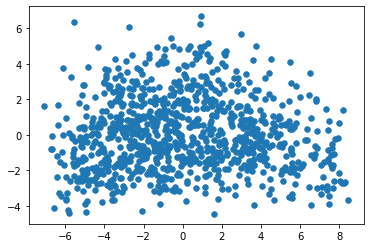

In [0]:
plt.scatter(pca_components[ : , 0], pca_components[ : , 1], s =30);

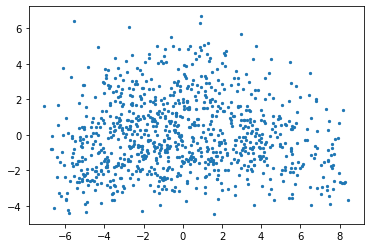

In [0]:
plt.scatter(pca_components[ : , 0], pca_components[ : , 1], s =5);

PCA doesn't return any visible clusters.

## t-SNE

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(nsee_df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 928 samples in 0.005s...
[t-SNE] Computed neighbors for 928 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 928 / 928
[t-SNE] Mean sigma: 2.471040
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.972519
[t-SNE] KL divergence after 300 iterations: 1.692554


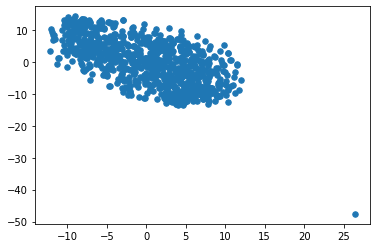

In [0]:
plt.scatter(tsne_results[ : , 0], tsne_results[ : , 1], s =30);

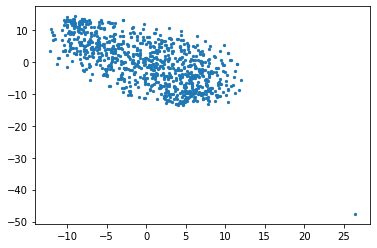

In [0]:
plt.scatter(tsne_results[ : , 0], tsne_results[ : , 1], s =5);

In [0]:
# decreasing perplexity
tsne2 = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results2 = tsne2.fit_transform(nsee_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 928 samples in 0.006s...
[t-SNE] Computed neighbors for 928 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 928 / 928
[t-SNE] Mean sigma: 2.349905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.226349
[t-SNE] KL divergence after 300 iterations: 1.743106


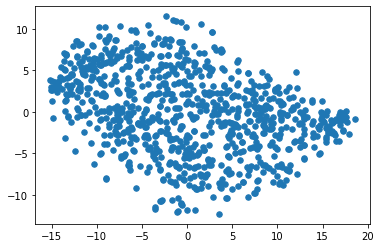

In [0]:
plt.scatter(tsne_results2[ : , 0], tsne_results2[ : , 1], s =30);

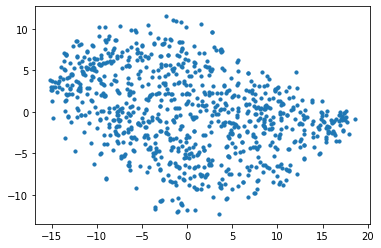

In [0]:
plt.scatter(tsne_results2[ : , 0], tsne_results2[ : , 1], s =10);

In [0]:
# increasing perplexity
tsne3 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results3 = tsne3.fit_transform(nsee_df)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 928 samples in 0.004s...
[t-SNE] Computed neighbors for 928 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 928 / 928
[t-SNE] Mean sigma: 2.568948
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.885201
[t-SNE] KL divergence after 300 iterations: 1.519289


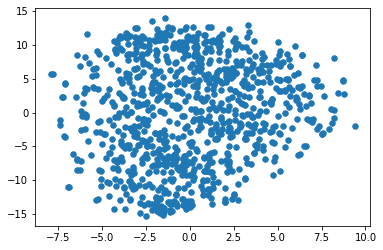

In [0]:
plt.scatter(tsne_results3[ : , 0], tsne_results3[ : , 1], s =30);

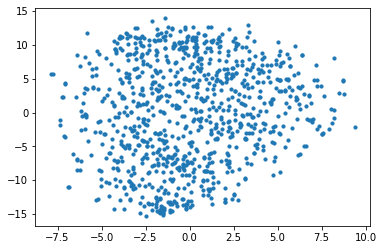

In [0]:
plt.scatter(tsne_results3[ : , 0], tsne_results3[ : , 1], s =10);

t-SNE also does not return clearly visible clusters. Interestingly, when perplexity is 40, there is one point that is distinct from the rest.

## UMAP

In [0]:
time_start = time.time()
umap_results = umap.UMAP(n_neighbors=5,
                         min_dist=0.3,
                         metric='correlation').fit_transform(nsee_df)
print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 1.5488643646240234 seconds


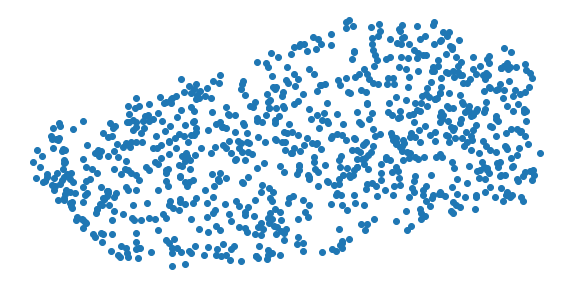

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [0]:
# decreasing neighbors
umap_results2 = umap.UMAP(n_neighbors=3,
                         min_dist=0.3,
                         metric='correlation').fit_transform(nsee_df)
print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 147.80299520492554 seconds


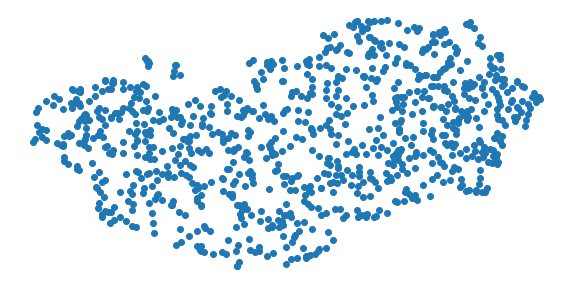

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results2[:, 0], umap_results2[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [0]:
# increasing neighbors
umap_results3 = umap.UMAP(n_neighbors=10,
                         min_dist=0.3,
                         metric='correlation').fit_transform(nsee_df)
print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 164.76023030281067 seconds


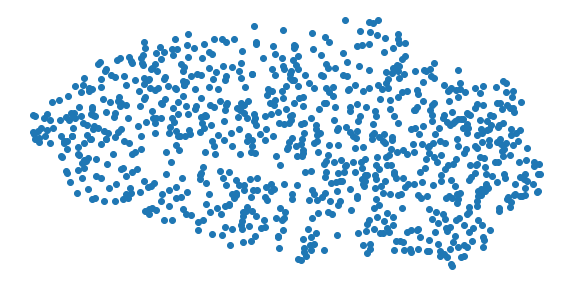

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results3[:, 0], umap_results3[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [0]:
# increasing min dist
umap_results4 = umap.UMAP(n_neighbors=3,
                         min_dist=0.5,
                         metric='correlation').fit_transform(nsee_df)
print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 185.53092980384827 seconds


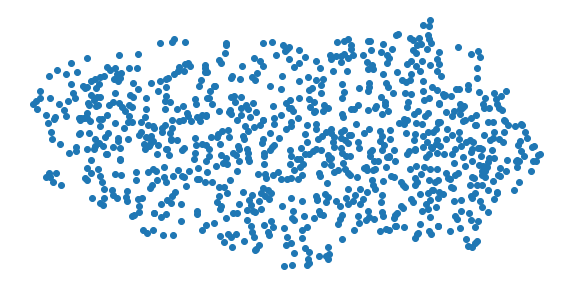

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results4[:, 0], umap_results4[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [0]:
# decreasing min dist
umap_results5 = umap.UMAP(n_neighbors=3,
                         min_dist=0.1,
                         metric='correlation').fit_transform(nsee_df)
print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 198.12686347961426 seconds


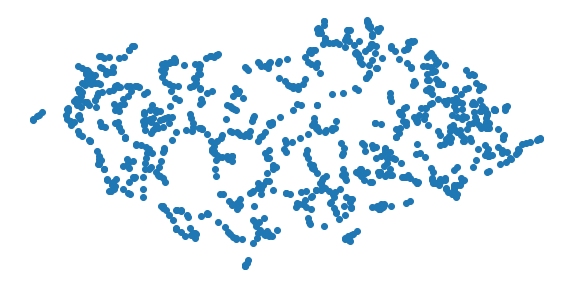

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results5[:, 0], umap_results5[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [0]:
# decreasing neighbors
umap_results6 = umap.UMAP(n_neighbors=2,
                         min_dist=0.1,
                         metric='correlation').fit_transform(nsee_df)
print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 139 separate connected components using meta-embedding (experimental)
  n_components


UMAP done! Time elapsed: 252.9410457611084 seconds


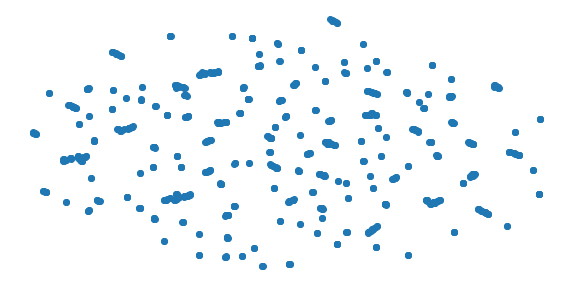

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results6[:, 0], umap_results6[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Again, there are not any discernable clusters. 

# Unsupervised Models

## K-Means

In [0]:
# standardizing data
scaler = StandardScaler()
X_std = scaler.fit_transform(nsee_df)

In [0]:
labels1 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels1, metric='euclidean'))

0.17034433323106327


In [0]:
labels2 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels2, metric='euclidean'))

0.10062005262038282


In [0]:
labels3 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels3, metric='euclidean'))

0.08278025966735528


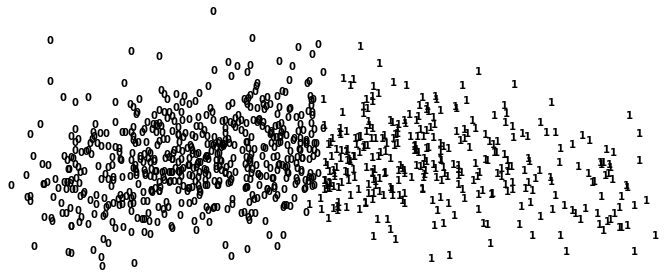

In [0]:
# visualizing k-means with 2 clusters
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(1,.5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(labels1[i]),
             fontdict={'weight': 'bold', 'size': 10}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

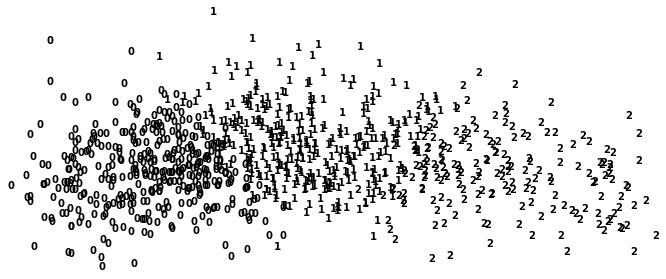

In [0]:
# visualizing k-means with 3 clusters
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(1,.5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(labels2[i]),
             fontdict={'weight': 'bold', 'size': 10}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

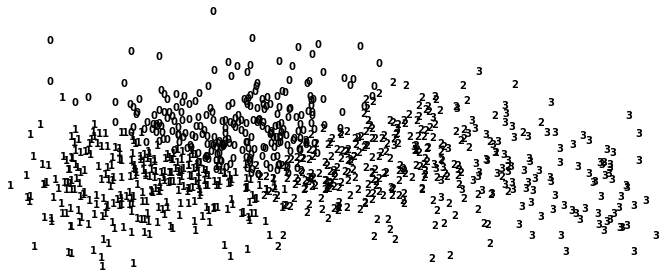

In [0]:
# visualizing k-means with 4 clusters
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(1,.5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(labels3[i]),
             fontdict={'weight': 'bold', 'size': 10}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## Hierarchical clustering

In [0]:
labels5 = AgglomerativeClustering(linkage='complete', affinity='cosine', 
                                  n_clusters=2).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels5, metric='euclidean'))

0.1083498888480654


In [0]:
labels6 = AgglomerativeClustering(linkage='complete', affinity='cosine', 
                                  n_clusters=3).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels6, metric='euclidean'))

0.0781027786527967


In [0]:
labels7 = AgglomerativeClustering(linkage='ward', affinity='euclidean', 
                                  n_clusters=2).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels7, metric='euclidean'))

0.15049830285097163


In [0]:
labels8 = AgglomerativeClustering(linkage='ward', affinity='euclidean', 
                                  n_clusters=3).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels8, metric='euclidean'))

0.101847719497278


In [0]:
labels9 = AgglomerativeClustering(linkage='ward', affinity='euclidean', 
                                  n_clusters=4).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels9, metric='euclidean'))

0.041870592449913716


In [0]:
labels10 = AgglomerativeClustering(linkage='average', affinity='cosine', 
                                  n_clusters=2).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels10, metric='euclidean'))

0.13604539216495784


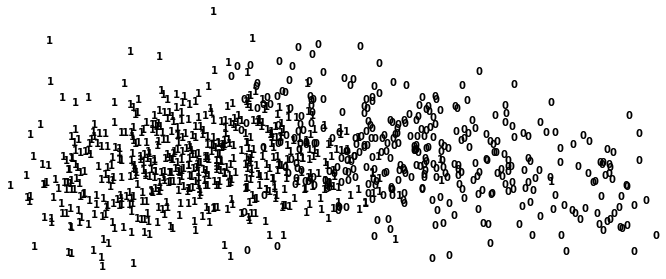

In [0]:
# visualizing best hierarchical
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(1,.5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(labels7[i]),
             fontdict={'weight': 'bold', 'size': 10}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## DBSCAN

In [0]:
labels11 = DBSCAN(eps=1, min_samples=5).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels11, metric='euclidean'))

ValueError: ignored

In [0]:
labels12 = DBSCAN(eps=5, min_samples=5).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels12, metric='euclidean'))

0.12896362489961496


In [0]:
labels13 = DBSCAN(eps=5, min_samples=10).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels13, metric='euclidean'))

0.12676423681833718


In [0]:
labels14 = DBSCAN(eps=6, min_samples=5).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels14, metric='euclidean'))

0.2024438622680221


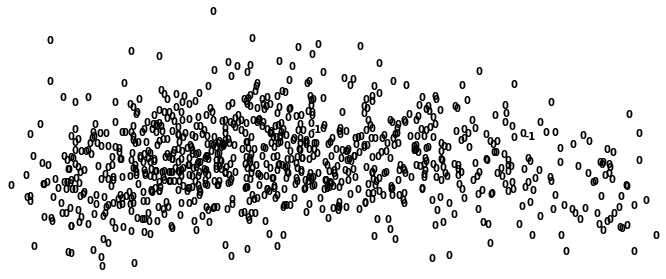

In [0]:
# visualizing best DBSCAN
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(1,.5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(labels14[i]),
             fontdict={'weight': 'bold', 'size': 10}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# Conclusion
Of all the models I explored, a DBSCAN with epsilon 6 has the highest silhouette score.  However, after visualizing clusters, I think the k-means with 2 clusters performs best.